In [1]:
import sys
sys.path.insert(0, "../")

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from copy import deepcopy
from hyperimpute.plugins.imputers import Imputers
from matplotlib import pyplot as plt
from scipy.stats import sem
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as reg_metric
from sklearn.metrics import mean_squared_error as reg_metric
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.dataloader import *
from src.metrics import *
from src.models import *
from triage.triage_torch import Triage
from src.utils import *

uci_datasets = [
    "boston",
    "protein",
    "bike",
    "star",
    "concrete",
    "bio",
]

EPOCHS = 20
n_runs = 10

# 'boston', 'concrete', 'protein', 'bike', 'star', 'concrete', 'bio', 'los', "mimic_antibiotics", "cancer"
dataset = "boston"

_ALL_REGRESSION_DATASETS = ALL_REGRESSION_DATASETS

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load & process datasets

In [2]:
processing_needed = False


if dataset != "cancer" and dataset not in uci_datasets:

    data = load_medical(dataset, seeded=True)  
    if len(data) == 4:
        df, outcome_variable, processing_needed, seed = data
    else:
        df_static, df_temporal, outcome_variable, processing_needed, seed = data

    if processing_needed:
        ids_static = df_static.id.unique()
        ids_temporal = df_temporal[df_temporal["time"] == 0].id.unique()

        if len(ids_temporal) < len(ids_static):
            ids = ids_temporal
        else:
            ids = ids_static

        df_static = df_static[df_static.id.isin(ids)]
        df_temporal = df_temporal[df_temporal.id.isin(ids)]
        df_temporal = df_temporal[df_temporal["time"] == 0]

        df_temporal_label = df_temporal[df_temporal["variable"] == outcome_variable]
        if len(df_temporal_label) == 0:
            df_temporal_label = df_static[[outcome_variable, "id"]]

        if len(df_temporal_label) != len(df_temporal):
            ids = df_temporal_label.id
            df_static = df_static[df_static.id.isin(ids)]
            df_temporal = df_temporal[df_temporal.id.isin(ids)]

        df_static.shape, df_temporal[df_temporal["variable"] == outcome_variable].shape

        df_temporal = df_temporal.sort_values(by=["id"])
        df_static = df_static.sort_values(by=["id"])

        temporal_unique_ids = df_temporal.id.unique().shape
        static_shape = df_static.shape
        assert temporal_unique_ids[0] == static_shape[0]

        feature_dict = {}
        for variable_name in list(df_temporal.variable.unique()):
            tdf = df_temporal[df_temporal["variable"] == variable_name]
            variable_array = tdf.drop_duplicates(subset=["id"]).value.to_numpy()
            feature_dict[variable_name] = variable_array

        tmp_df = pd.DataFrame.from_dict(
            feature_dict, columns=df_static.id, orient="index"
        ).T.reset_index(level=0)

        temporal_shape = tmp_df.shape
        df_overall = df_static.merge(tmp_df, on="id", how="left")

        assert df_overall[outcome_variable].shape[0] == static_shape[0]

    else:
        df_overall = df


# Split data

In [3]:
###########################################
# DATA SETUP
###########################################


if dataset != "cancer" and dataset not in uci_datasets:
    X = df_overall.drop(columns=[outcome_variable])
    y = df_overall[outcome_variable].values

if dataset in uci_datasets:
    regression_datasets = list(_ALL_REGRESSION_DATASETS.keys())
    regression_datasets.sort()

    if dataset in regression_datasets:
        # xlrd, openpyxl
        import tempfile

        dataset_name = regression_datasets[mapper[dataset]]
        with tempfile.TemporaryDirectory() as data_dir:
            # download and load data
            download_regression_dataset(dataset_name, data_dir)
            X, y, seed = load_regression_dataset(
                dataset_name, data_dir, seeded=True, shuffle_train=True, batch_size=512
            )
            print(dataset)
    else:
        X, y, seed = GetDataset(dataset, "../data/", seeded=True)

if dataset == "cancer":
    X, y, df = load_seer_cutract_dataset("seer",42)
    y = y.values
    seed=100

if dataset not in uci_datasets:
    df_overall = deepcopy(X)
    df_overall["y"] = y

seed_everything(seed=seed)


y = np.array([(y[i] - y.min()) / (y.max() - y.min()) for i in range(len(y))])

# Impute missing data --- relevant especially for the medical datasets

imputers = Imputers()
method = "mean"
plugin = Imputers().get(method)
X = plugin.fit_transform(X.copy())


scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

###########################################
# DATA PROCESSING
###########################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.25
)

boston


# Run characterization

In [4]:
x_train = torch.FloatTensor(X_prop_train).to(device)
y_train = torch.FloatTensor(y_prop_train).to(device)
X_cal = torch.FloatTensor(X_cal).to(device)
y_cal = torch.FloatTensor(y_cal).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

y_eval = y_train
X_eval = x_train

grad_X = deepcopy(x_train)
grad_Y = deepcopy(y_train)


###########################################
# DATALOADER
###########################################


train_data = TrainData(torch.FloatTensor(X_prop_train).to(device), torch.FloatTensor(y_prop_train).to(device))
trainloader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)


###########################################
# MODEL SETUP
###########################################
n_feats = x_train.shape[1]
mlp = Net1(input_size=n_feats, nlabels=1)
mlp = mlp.to(device)

# Define the loss function and optimizer
loss_function = nn.L1Loss(reduction="none")
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)


vog = {}
loss_values = []


triage_metric = None
interval_array = None
errors_array = None

gn = grad_norm(X=x_train, y=y_train)

try:

    triage = Triage(X_eval=X_eval, y_eval=y_eval, X_cal=X_cal, y_cal=y_cal, learner=mlp)

    # Run the training loop
    for epoch in tqdm(range(0, EPOCHS)):
        mlp.train()
        # Set current loss value
        current_loss = 0.0

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(x_train)

        # Compute loss
        loss_each = loss_function(outputs, y_train)

        ###########################################
        # per-sample loss
        ###########################################
        loss = loss_each.mean()  # torch.mean(loss_each)
        loss_each = torch.mean(loss_each.detach(), 1)
        loss_values.append(loss_each.detach().cpu().numpy())

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss = loss.item()

        print(f"Epoch {epoch} = {current_loss}")

        # gradient norm
        gn.gradient(net=mlp, device=device)
        ######################################################################################

        ######################################################################################

        # EVALUATION

        mlp.eval()

        ###########################################
        # TRIAGE
        ###########################################
        groups_ids, raw_metrics = triage.run(learner=mlp)

        ###########################################
        # Variance of gradients (VOG)
        ###########################################
        # Get gradients
        grad_X.requires_grad = True
        sel_nodes_shape = grad_Y.shape
        ones = torch.ones(sel_nodes_shape).to(device)
        outputs = mlp(grad_X)
        sel_nodes = outputs[torch.arange(len(grad_Y))]

        try:
            sel_nodes.backward(ones)
        except:
            ones = torch.unsqueeze(ones, dim=-1)
            sel_nodes.backward(ones)
        grad = grad_X.grad.data.cpu().numpy()
        for i in range(grad_X.shape[0]):
            if i not in vog.keys():
                vog[i] = []
                vog[i].append(grad[i, :].tolist())
            else:
                vog[i].append(grad[i, :].tolist())

except:
    import traceback
    print(traceback.format_exc())

grad_X = grad_X.detach().cpu().numpy()
training_vog_stats, training_labels = vog_scores(grad_X, grad_Y, vog)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 = 0.4480539858341217


/Users/nabeel/Documents/GitHub/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/Users/nabeel/Documents/GitHub/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/Users/nabeel/Documents/Project code/triage/new_env_triage/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the docume

Epoch 1 = 0.44592785835266113
Epoch 2 = 0.44397664070129395
Epoch 3 = 0.44213777780532837


/Users/nabeel/Documents/GitHub/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/Users/nabeel/Documents/GitHub/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/Users/nabeel/Documents/Project code/triage/new_env_triage/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the docume

Epoch 4 = 0.4403890073299408
Epoch 5 = 0.43869447708129883
Epoch 6 = 0.437039852142334
Epoch 7 = 0.4354565441608429
Epoch 8 = 0.4339386820793152


/Users/nabeel/Documents/Project code/triage/new_env_triage/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/nabeel/Documents/GitHub/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/Users/nabeel/Documents/GitHub/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Epoch 9 = 0.4324704110622406
Epoch 10 = 0.43104493618011475
Epoch 11 = 0.429660439491272
Epoch 12 = 0.4283100366592407


/Users/nabeel/Documents/Project code/triage/new_env_triage/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/nabeel/Documents/GitHub/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/Users/nabeel/Documents/GitHub/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Epoch 13 = 0.42698535323143005
Epoch 14 = 0.42569801211357117
Epoch 15 = 0.4244511127471924
Epoch 16 = 0.4232466220855713


/Users/nabeel/Documents/Project code/triage/new_env_triage/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/nabeel/Documents/GitHub/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/Users/nabeel/Documents/GitHub/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

Epoch 17 = 0.4220879077911377
Epoch 18 = 0.42096301913261414
Epoch 19 = 0.41987156867980957


In [5]:
triage_metric = np.array(raw_metrics["score_metric"])
loss_values = np.array(loss_values).T
loss_mean = np.mean(loss_values, axis=1)

# aleatoric_uncertainty = np.std(metric, axis=-1) #np.mean(metric * (1 - metric), axis=-1)
confidence = np.mean(triage_metric, axis=-1)
vog = np.array(training_vog_stats)
errors_array = triage._errors_array

In [6]:
mlp.eval()
y_hat_test = mlp(X_test)
y_hat_test = y_hat_test.detach().cpu().numpy().reshape(-1)
y_test = y_test.detach().cpu().numpy().reshape(-1)
base_result = reg_metric(y_test, y_hat_test)

# Helper functions for data sculpting

In [7]:
def sculpt(X_prop_train, X_calib, y_prop_train, y_cal, X_test, y_test, ids, seed=None):

    if seed != None:
        seed_everything(seed)

    x_train = torch.FloatTensor(X_prop_train[ids, :]).to(device)
    y_train = torch.FloatTensor(y_prop_train[ids]).to(device)
 
    ###########################################
    # DATALOADER
    ###########################################
    train_data = TrainData(
        torch.FloatTensor(X_prop_train).to(device), torch.FloatTensor(y_prop_train).to(device)
    )
    trainloader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)

    ###########################################
    # MODEL SETUP
    ###########################################
    n_feats = x_train.shape[1]
    mlp_sculpt = Net1(input_size=n_feats, nlabels=1)
    mlp_sculpt = mlp_sculpt.to(device)

    # Define the loss function and optimizer
    loss_function = nn.L1Loss(reduction="none")
    optimizer = torch.optim.Adam(mlp_sculpt.parameters(), lr=0.001)

    # Run the training loop
    for epoch in range(0, EPOCHS):
        mlp_sculpt.train()
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp_sculpt(x_train)

        # Compute loss
        loss_each = loss_function(outputs, y_train)
        loss = loss_each.mean()

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

    mlp_sculpt.eval()
    y_hat_test = mlp_sculpt(X_test)
    y_hat_test = y_hat_test.detach().cpu().numpy().reshape(-1)
    return reg_metric(y_test, y_hat_test)


def get_well_estimated(upper, lower, triage_metric):
    percentile_thresh = 75
    conf_thresh_low = lower
    conf_thresh_high = upper

    variability = np.std(triage_metric, axis=-1)
    confidence = np.mean(triage_metric, axis=-1)

    oe_group = np.where(
        (confidence <= conf_thresh_low)
        & (variability <= np.percentile(variability, percentile_thresh))
    )[0]
    ue_group = np.where(
        (confidence >= conf_thresh_high)
        & (variability <= np.percentile(variability, percentile_thresh))
    )[0]

    other_ids = np.concatenate((oe_group, ue_group))
    we_ids = []
    for id in range(len(confidence)):
        if id not in other_ids:
            we_ids.append(id)

    we_ids = np.array(we_ids)

    return we_ids

In [8]:
errors_array

array([[0.57031775, 0.56790143, 0.56564325, ..., 0.5431554 , 0.5421554 ,
        0.54115534],
       [0.36095276, 0.35953206, 0.3581429 , ..., 0.3382055 , 0.33692923,
        0.33566502],
       [0.4170698 , 0.41524687, 0.41380566, ..., 0.3935426 , 0.39224184,
        0.3909542 ],
       ...,
       [0.2781847 , 0.2767411 , 0.27531126, ..., 0.25480887, 0.25347626,
        0.25226647],
       [0.49629152, 0.49352288, 0.49132812, ..., 0.469822  , 0.468822  ,
        0.46782202],
       [0.6151066 , 0.61350733, 0.6119288 , ..., 0.589822  , 0.588822  ,
        0.58782196]], dtype=float32)

# Plot sculpting curves

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


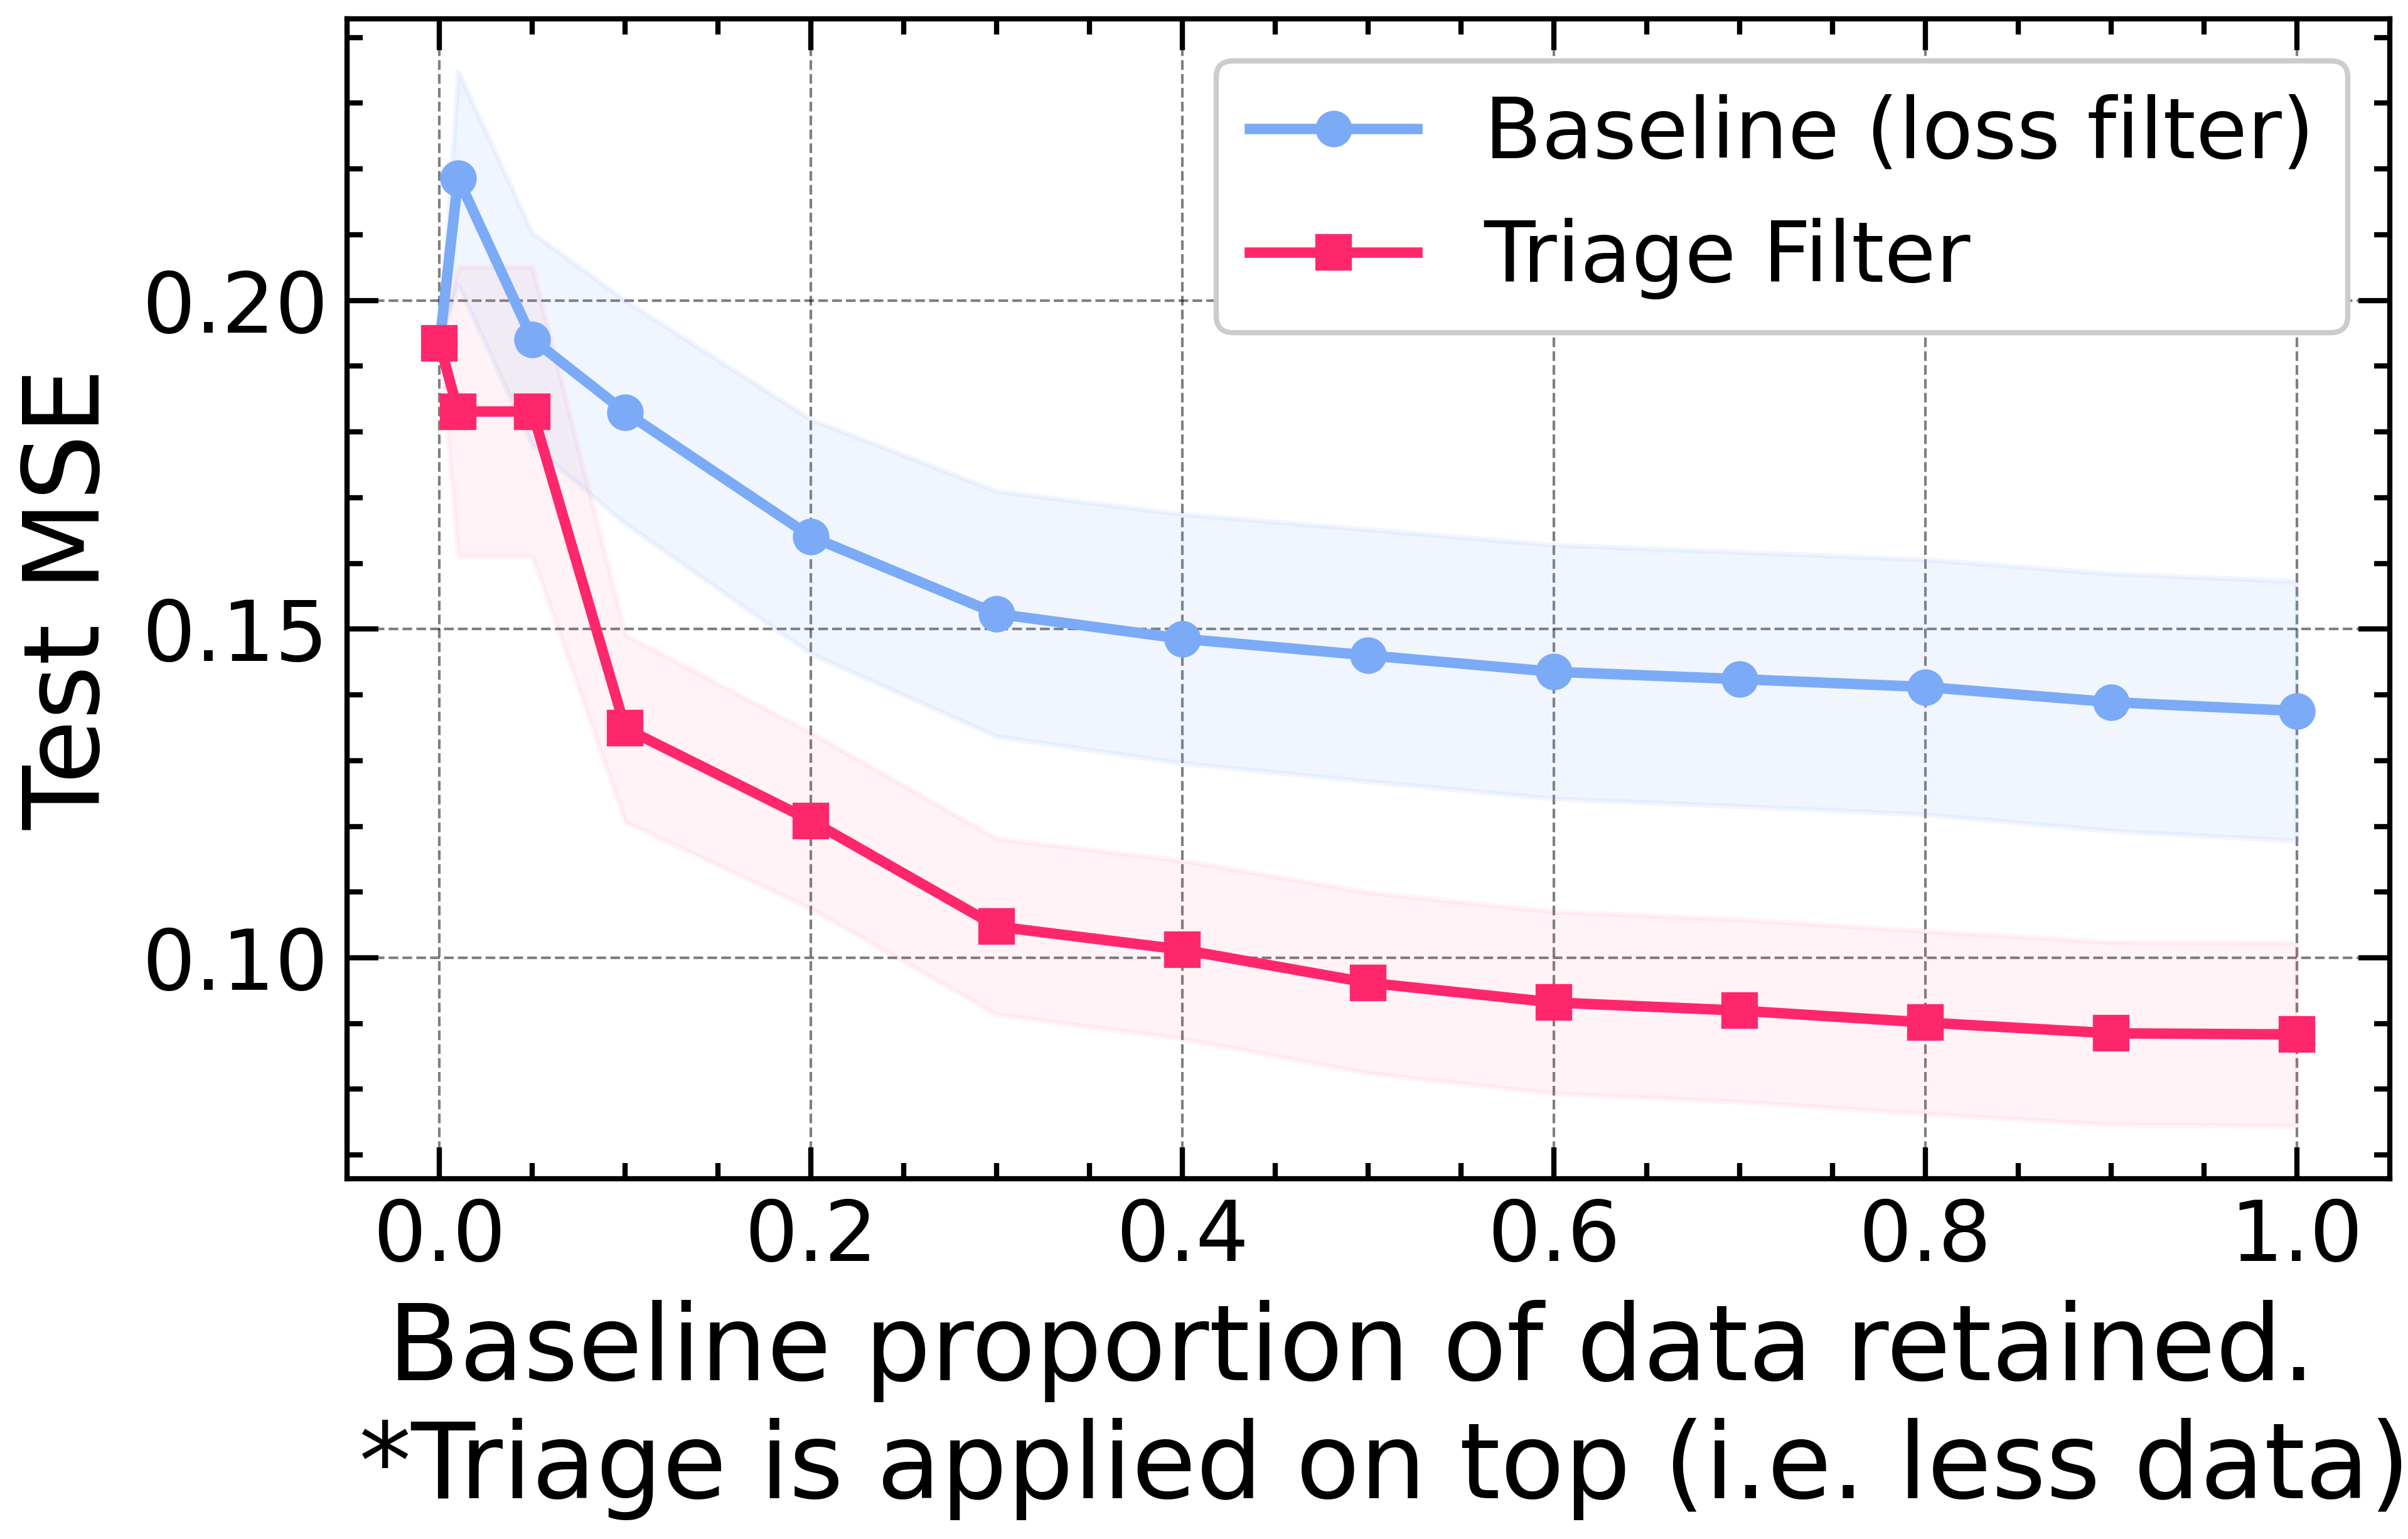

100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


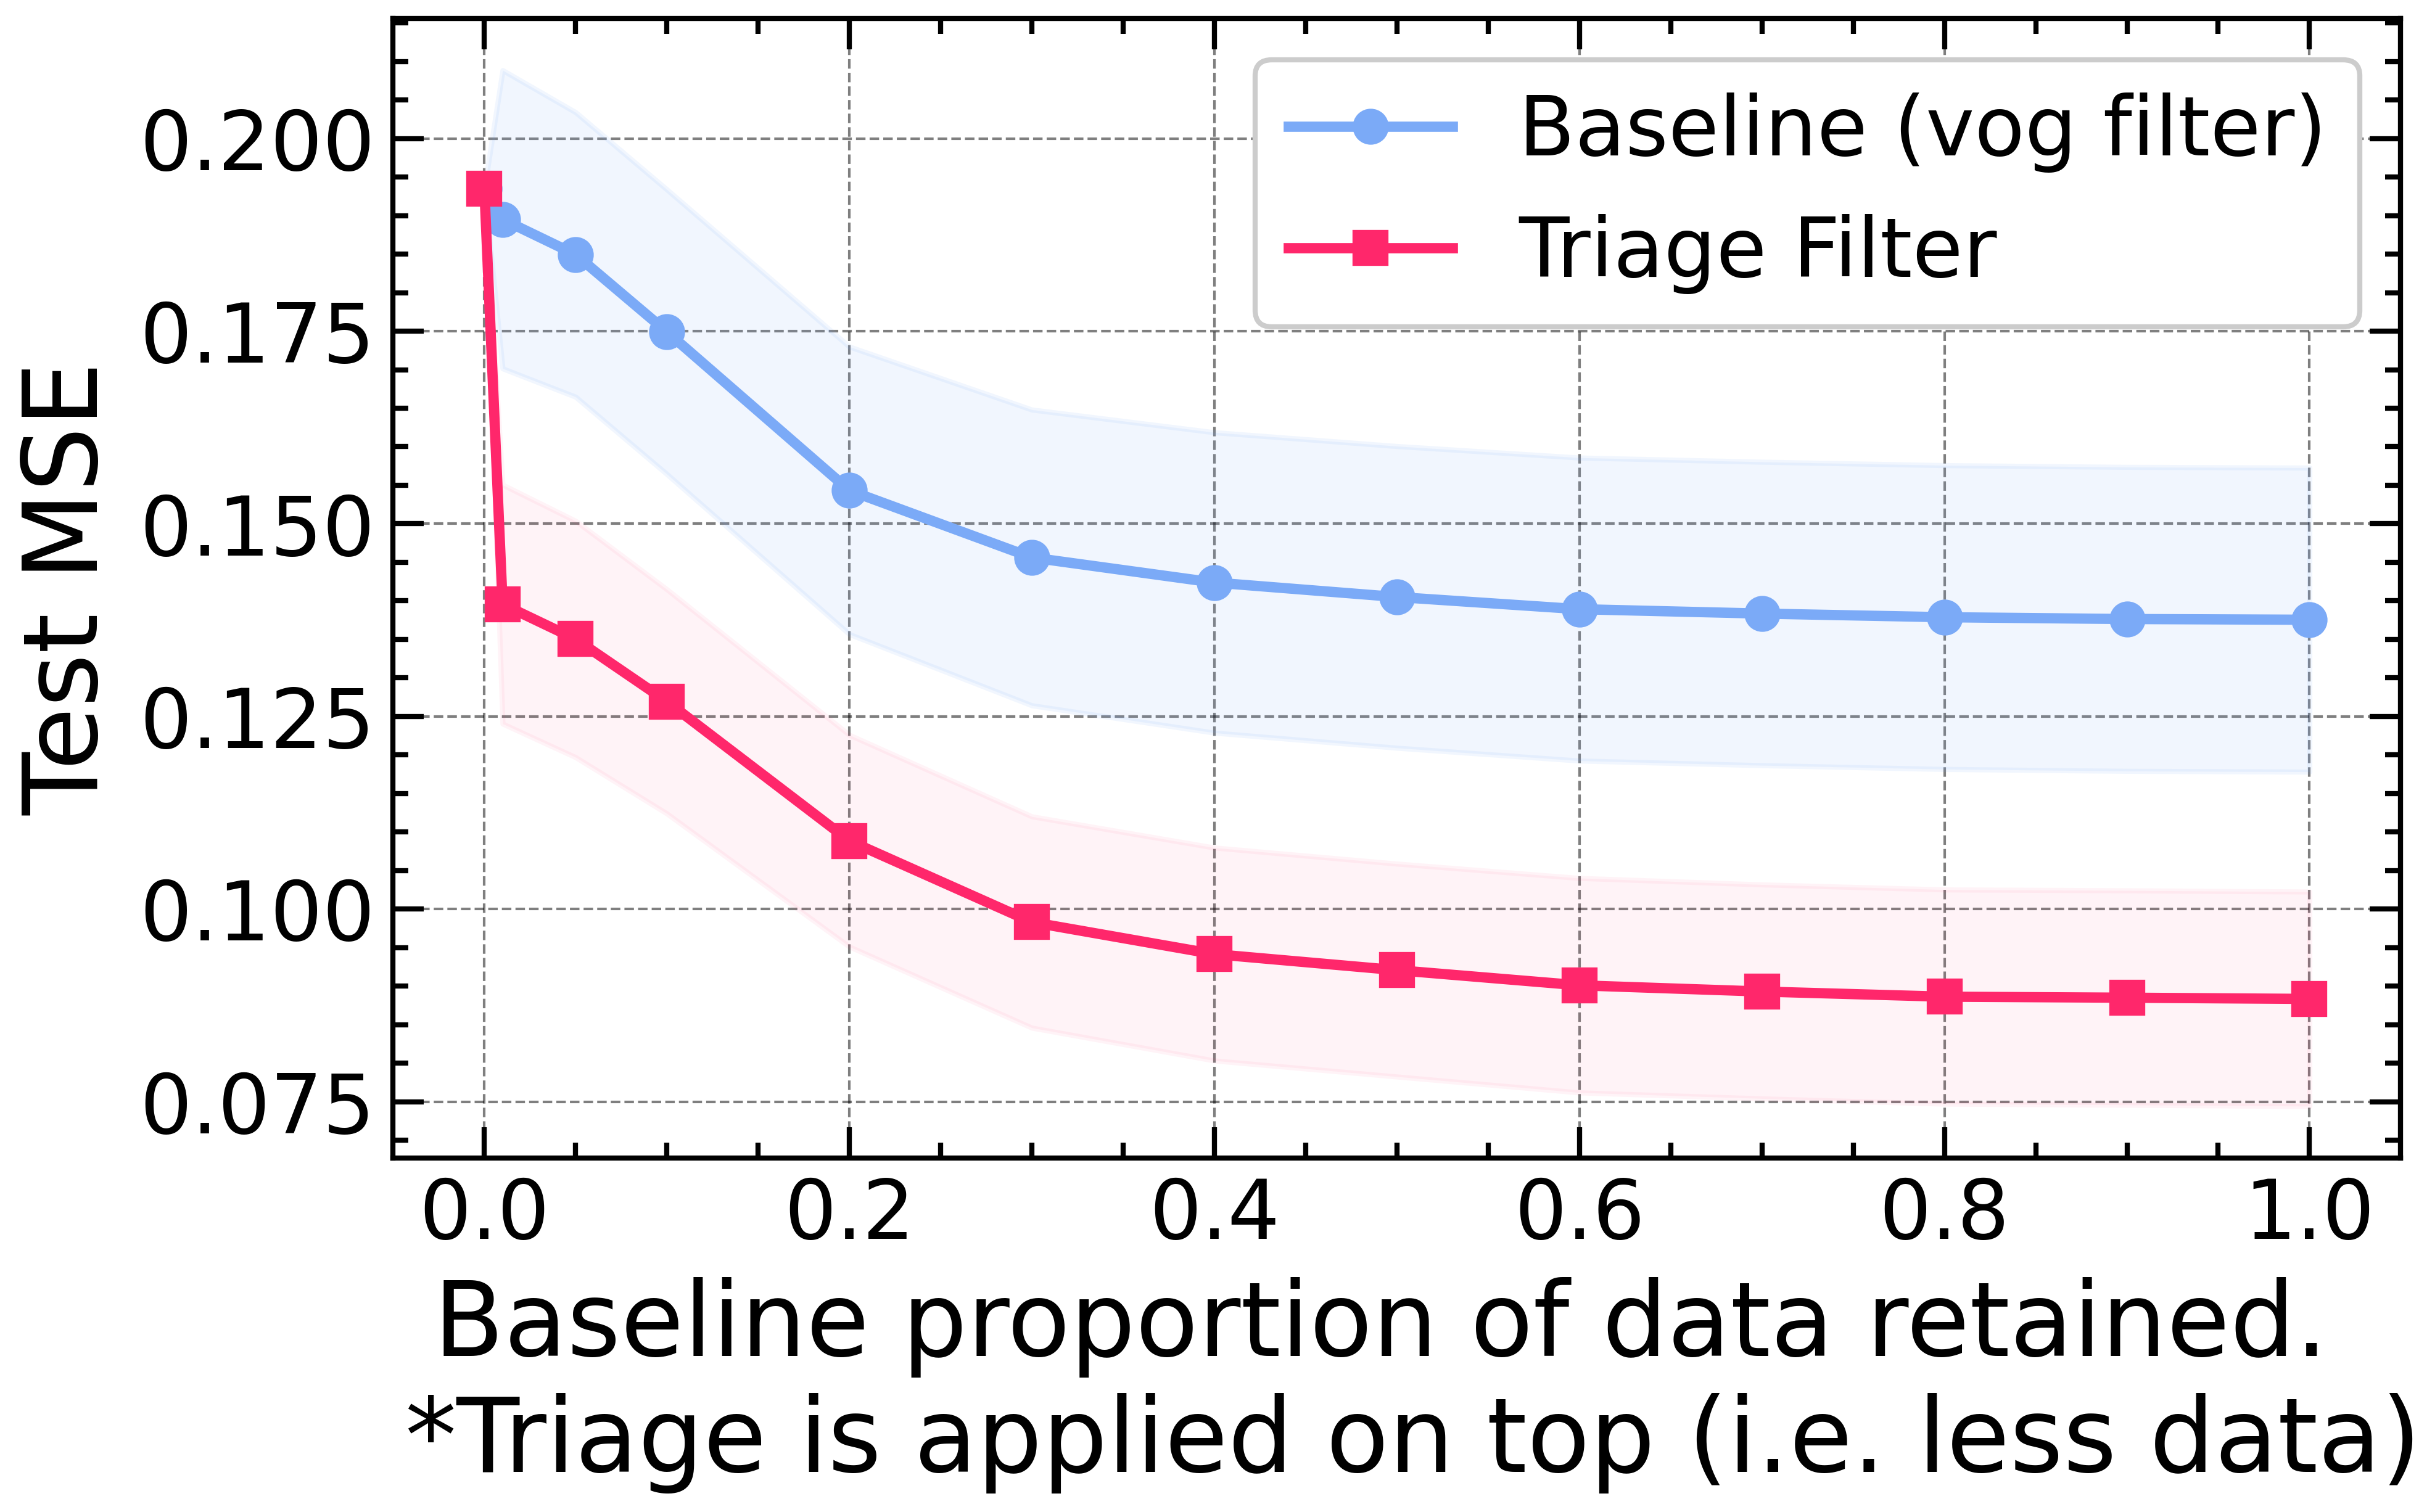

100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


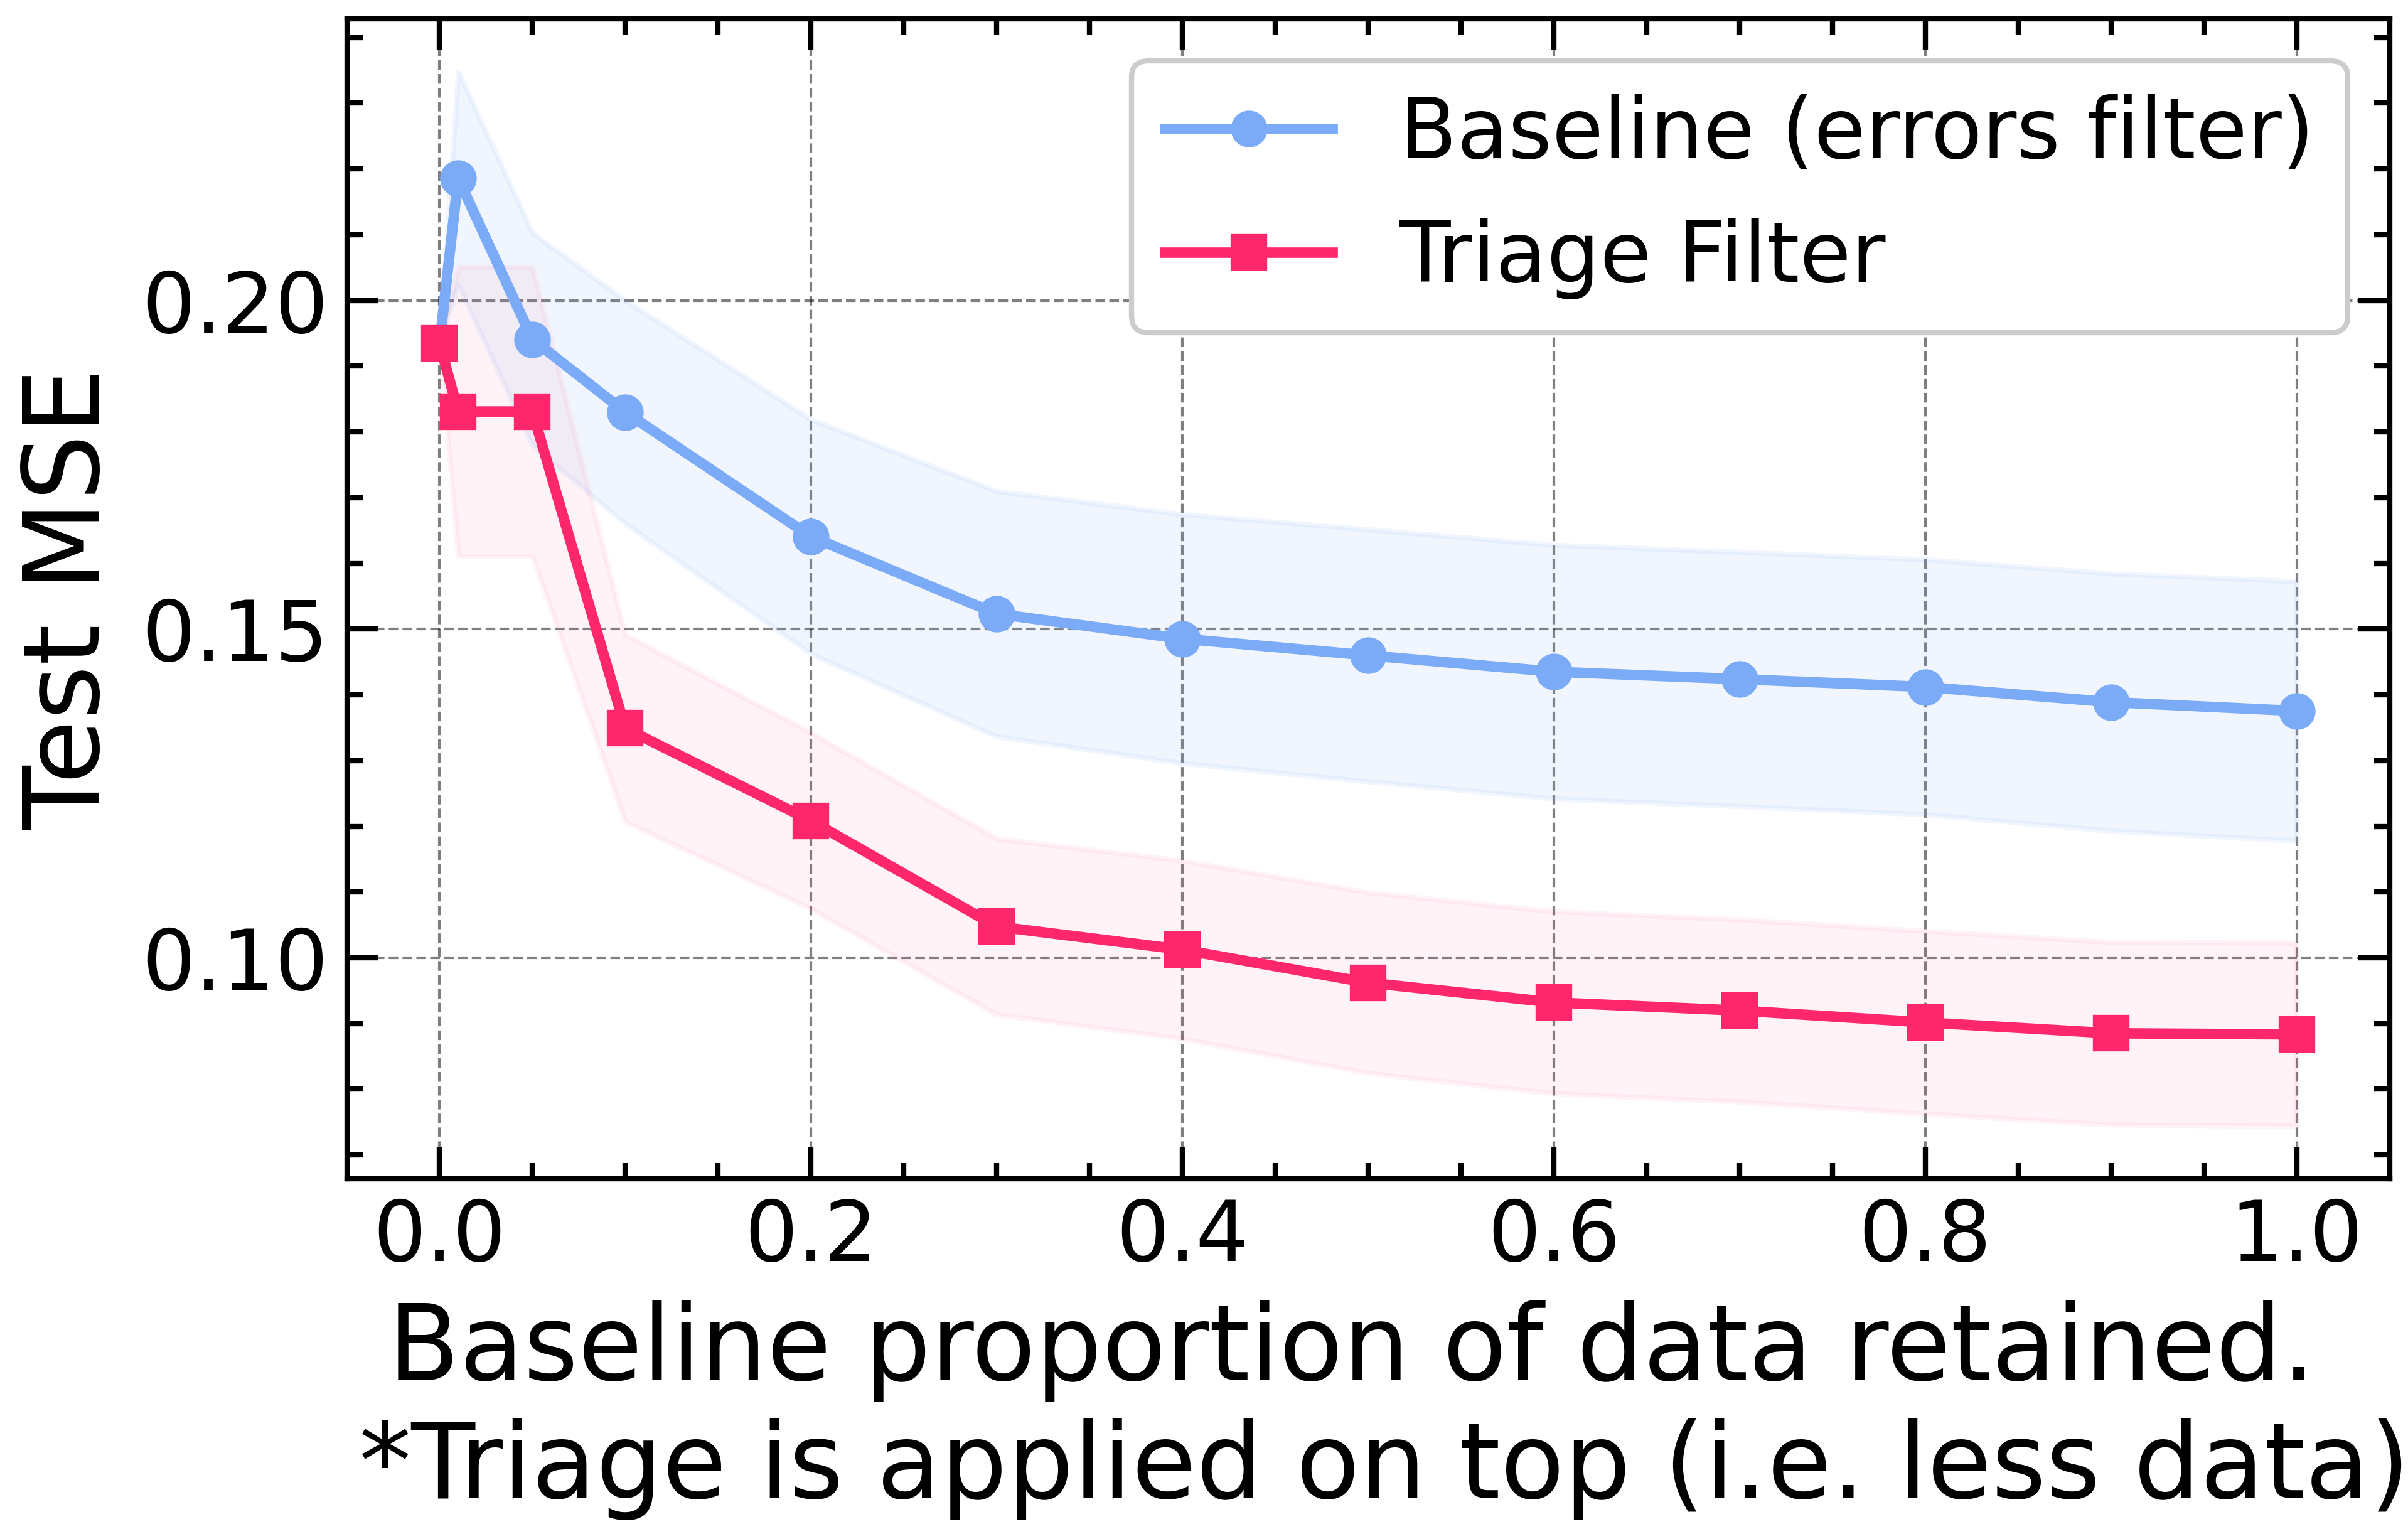

100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


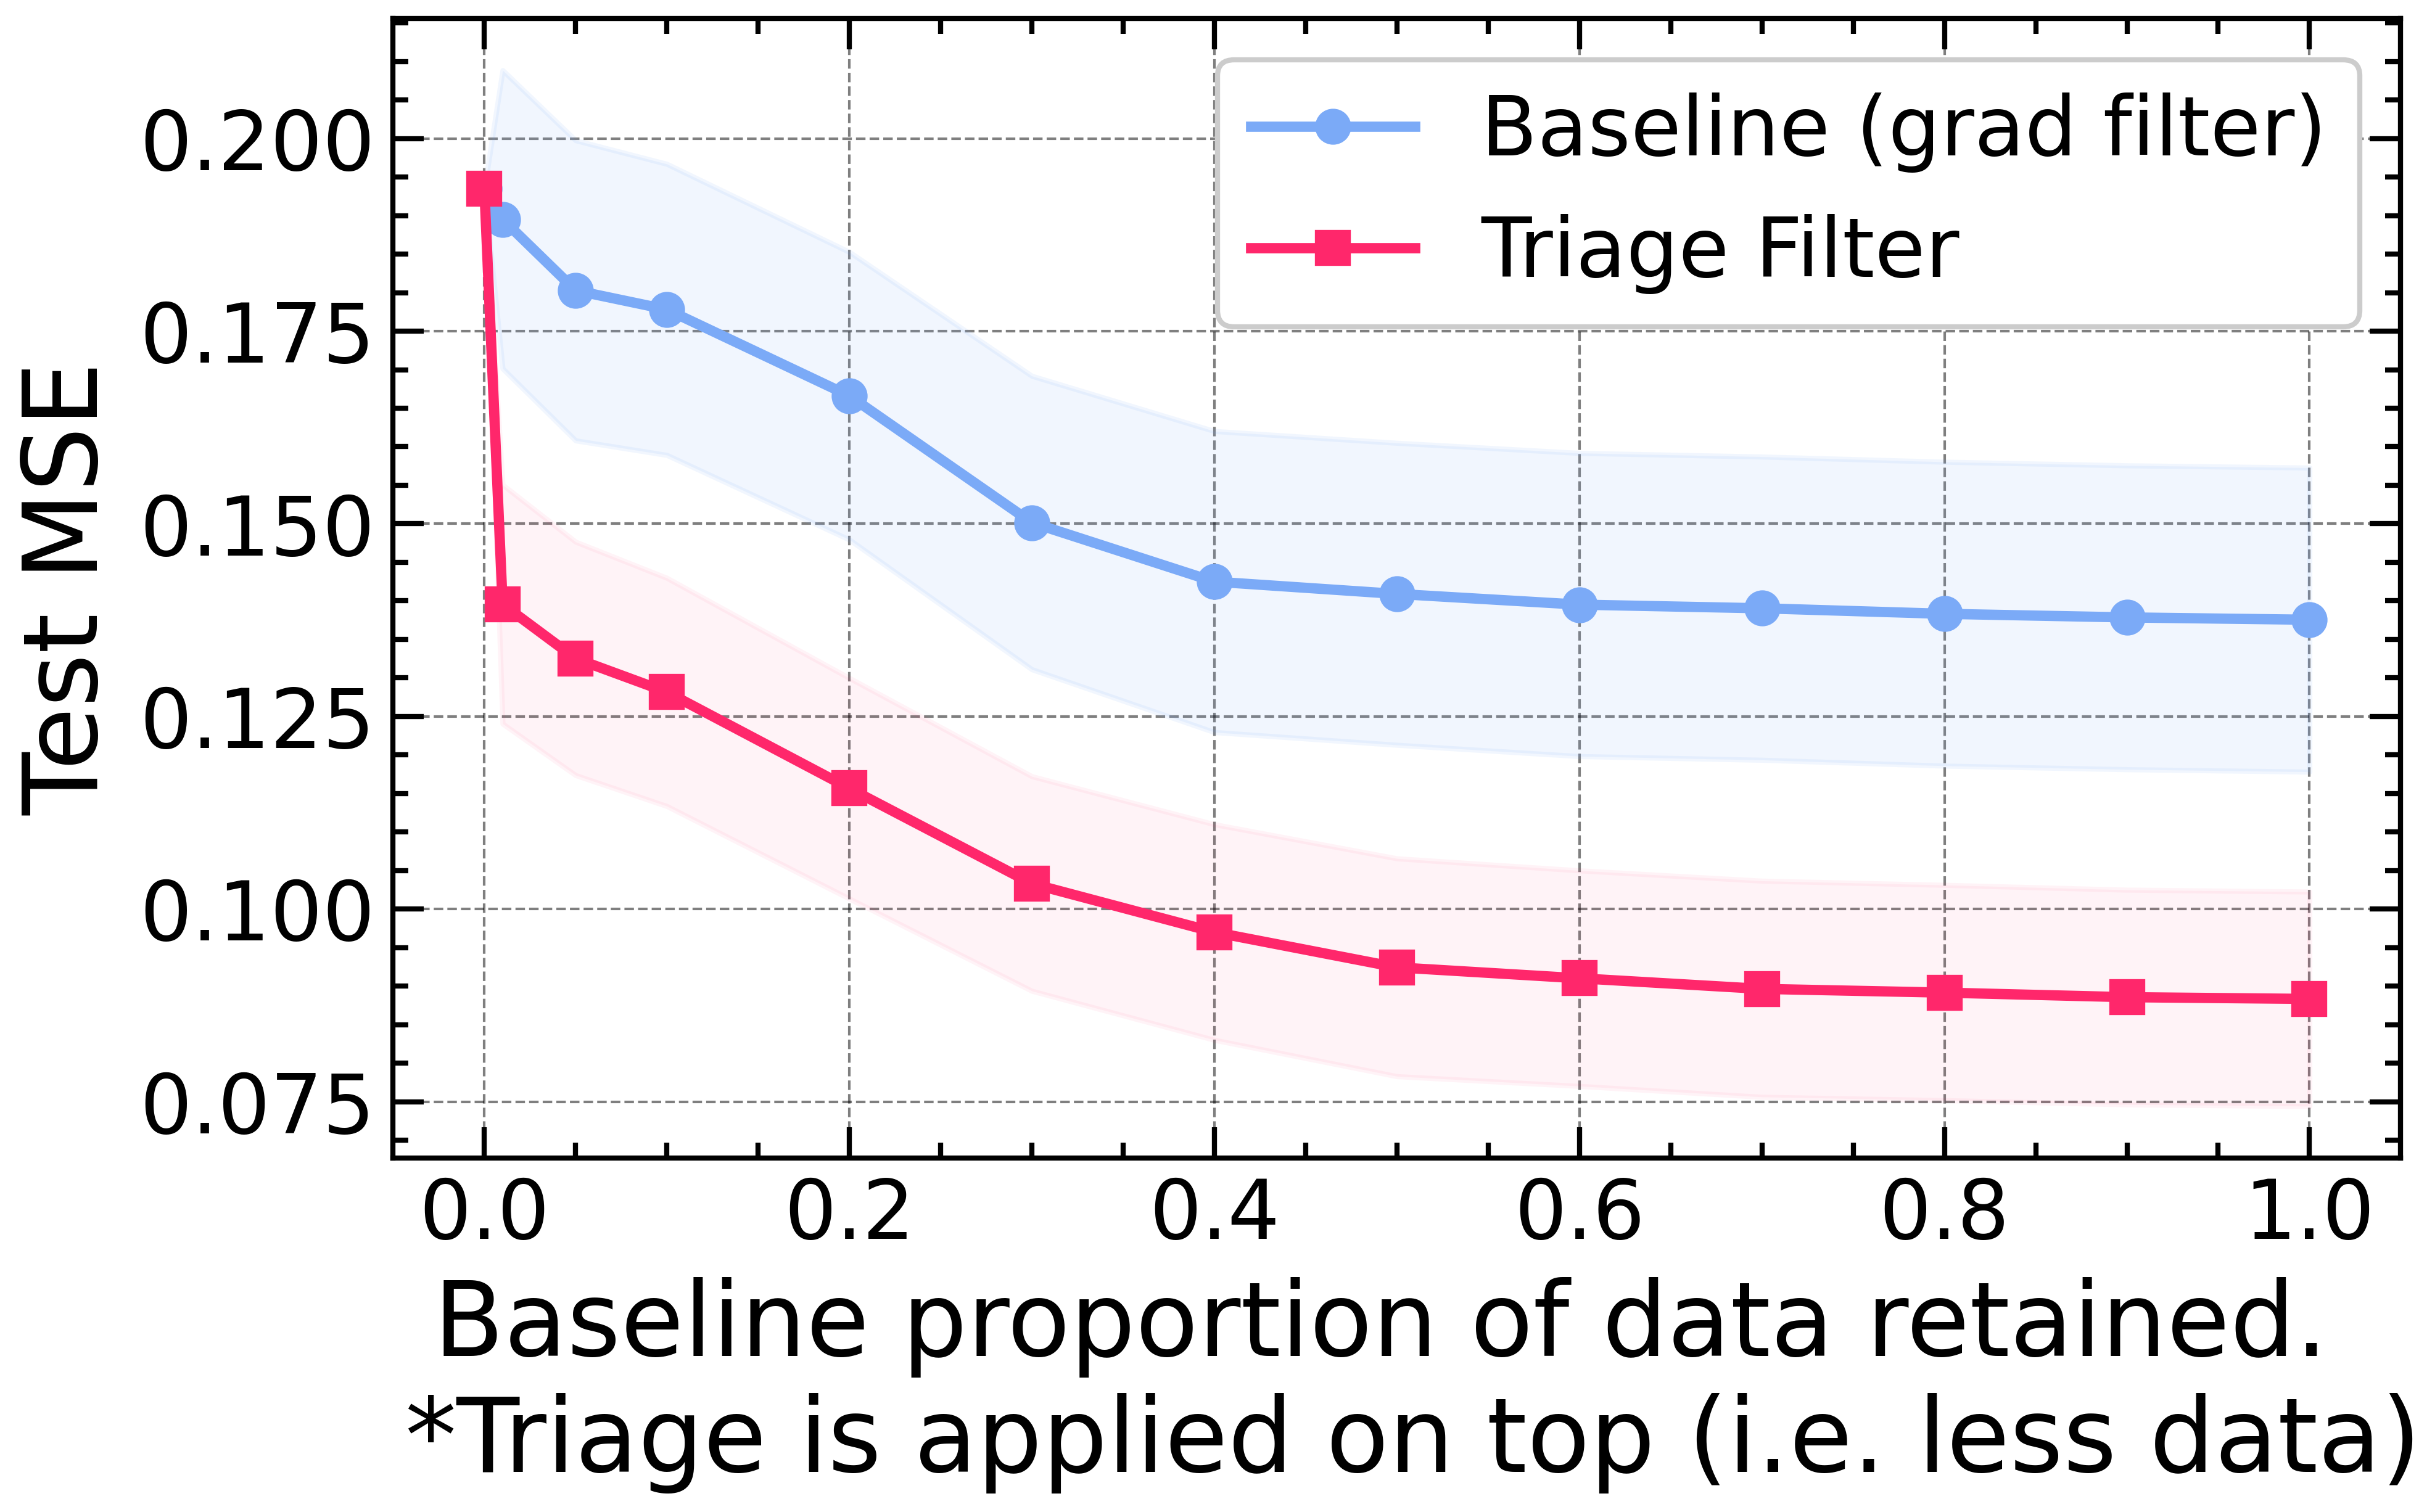

In [9]:
import warnings
warnings.filterwarnings("ignore")
plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])

metrics_eval = {
    "loss": loss_mean,
    "vog": vog,
    "errors": np.abs(np.mean(errors_array, axis=-1)),
    "grad": np.mean(np.array(gn._grads), axis=-1),
}

for metric in metrics_eval.keys():

    sculpt_metric = metrics_eval[metric]

    triage_mean = []
    triage_std = []

    base_mean = []
    base_std = []

    props = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    for prop in tqdm(props):

        base_list = []
        triage_list = []

        vals = int(prop * len(X_prop_train))

        ids = np.argsort(sculpt_metric)[0:vals]
        prop_ids = len(ids) / len(sculpt_metric)

        for run in range(n_runs):
            seed_everything(run * seed)

            score = sculpt(
                X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, ids
            )
            base_list.append(score)

            upper = 0.66
            lower = 0.33
            proba_ids = get_well_estimated(
                upper=upper, lower=lower, triage_metric=triage_metric
            )
            ids_new = np.intersect1d(proba_ids, ids)
            prop_ids_30 = len(ids_new) / len(sculpt_metric)
            score = sculpt(
                X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, ids_new
            )
            triage_list.append(score)

        base_mean.append(np.mean(base_list))
        triage_mean.append(np.mean(triage_list))

        base_std.append(sem(base_list) / 2)
        triage_std.append(sem(triage_list) / 2)

    props.insert(0, 0)
    base_mean.insert(0, base_result)
    triage_mean.insert(0, base_result)

    base_std.insert(0, 0)
    triage_std.insert(0, 0)

    # convert to numpy
    props = np.array(props)
    base_mean = np.array(base_mean)
    base_std = np.array(base_std)
    triage_mean = np.array(triage_mean)
    triage_std = np.array(triage_std)

    plt.figure(figsize=(7, 4))
    plt.plot(
        props,
        base_mean,
        label=f"Baseline ({metric} filter)",
        marker="o",
        color="#7BAAF7",
    )
    plt.fill_between(
        props, base_mean - base_std, base_mean + base_std, alpha=0.1, color="#7BAAF7"
    )

    plt.plot(props, triage_mean, label="Triage Filter", marker="s", color="#FF276B")
    plt.fill_between(
        props,
        triage_mean - triage_std,
        triage_mean + triage_std,
        alpha=0.05,
        color="#FF276B",
    )

    plt.legend()
    plt.ylabel("Test MSE", fontsize=20)
    plt.xlabel(
        "Baseline proportion of data retained. \n *Triage is applied on top (i.e. less data)",
        fontsize=20,
    )
    plt.show()

## Plot differentiation plots

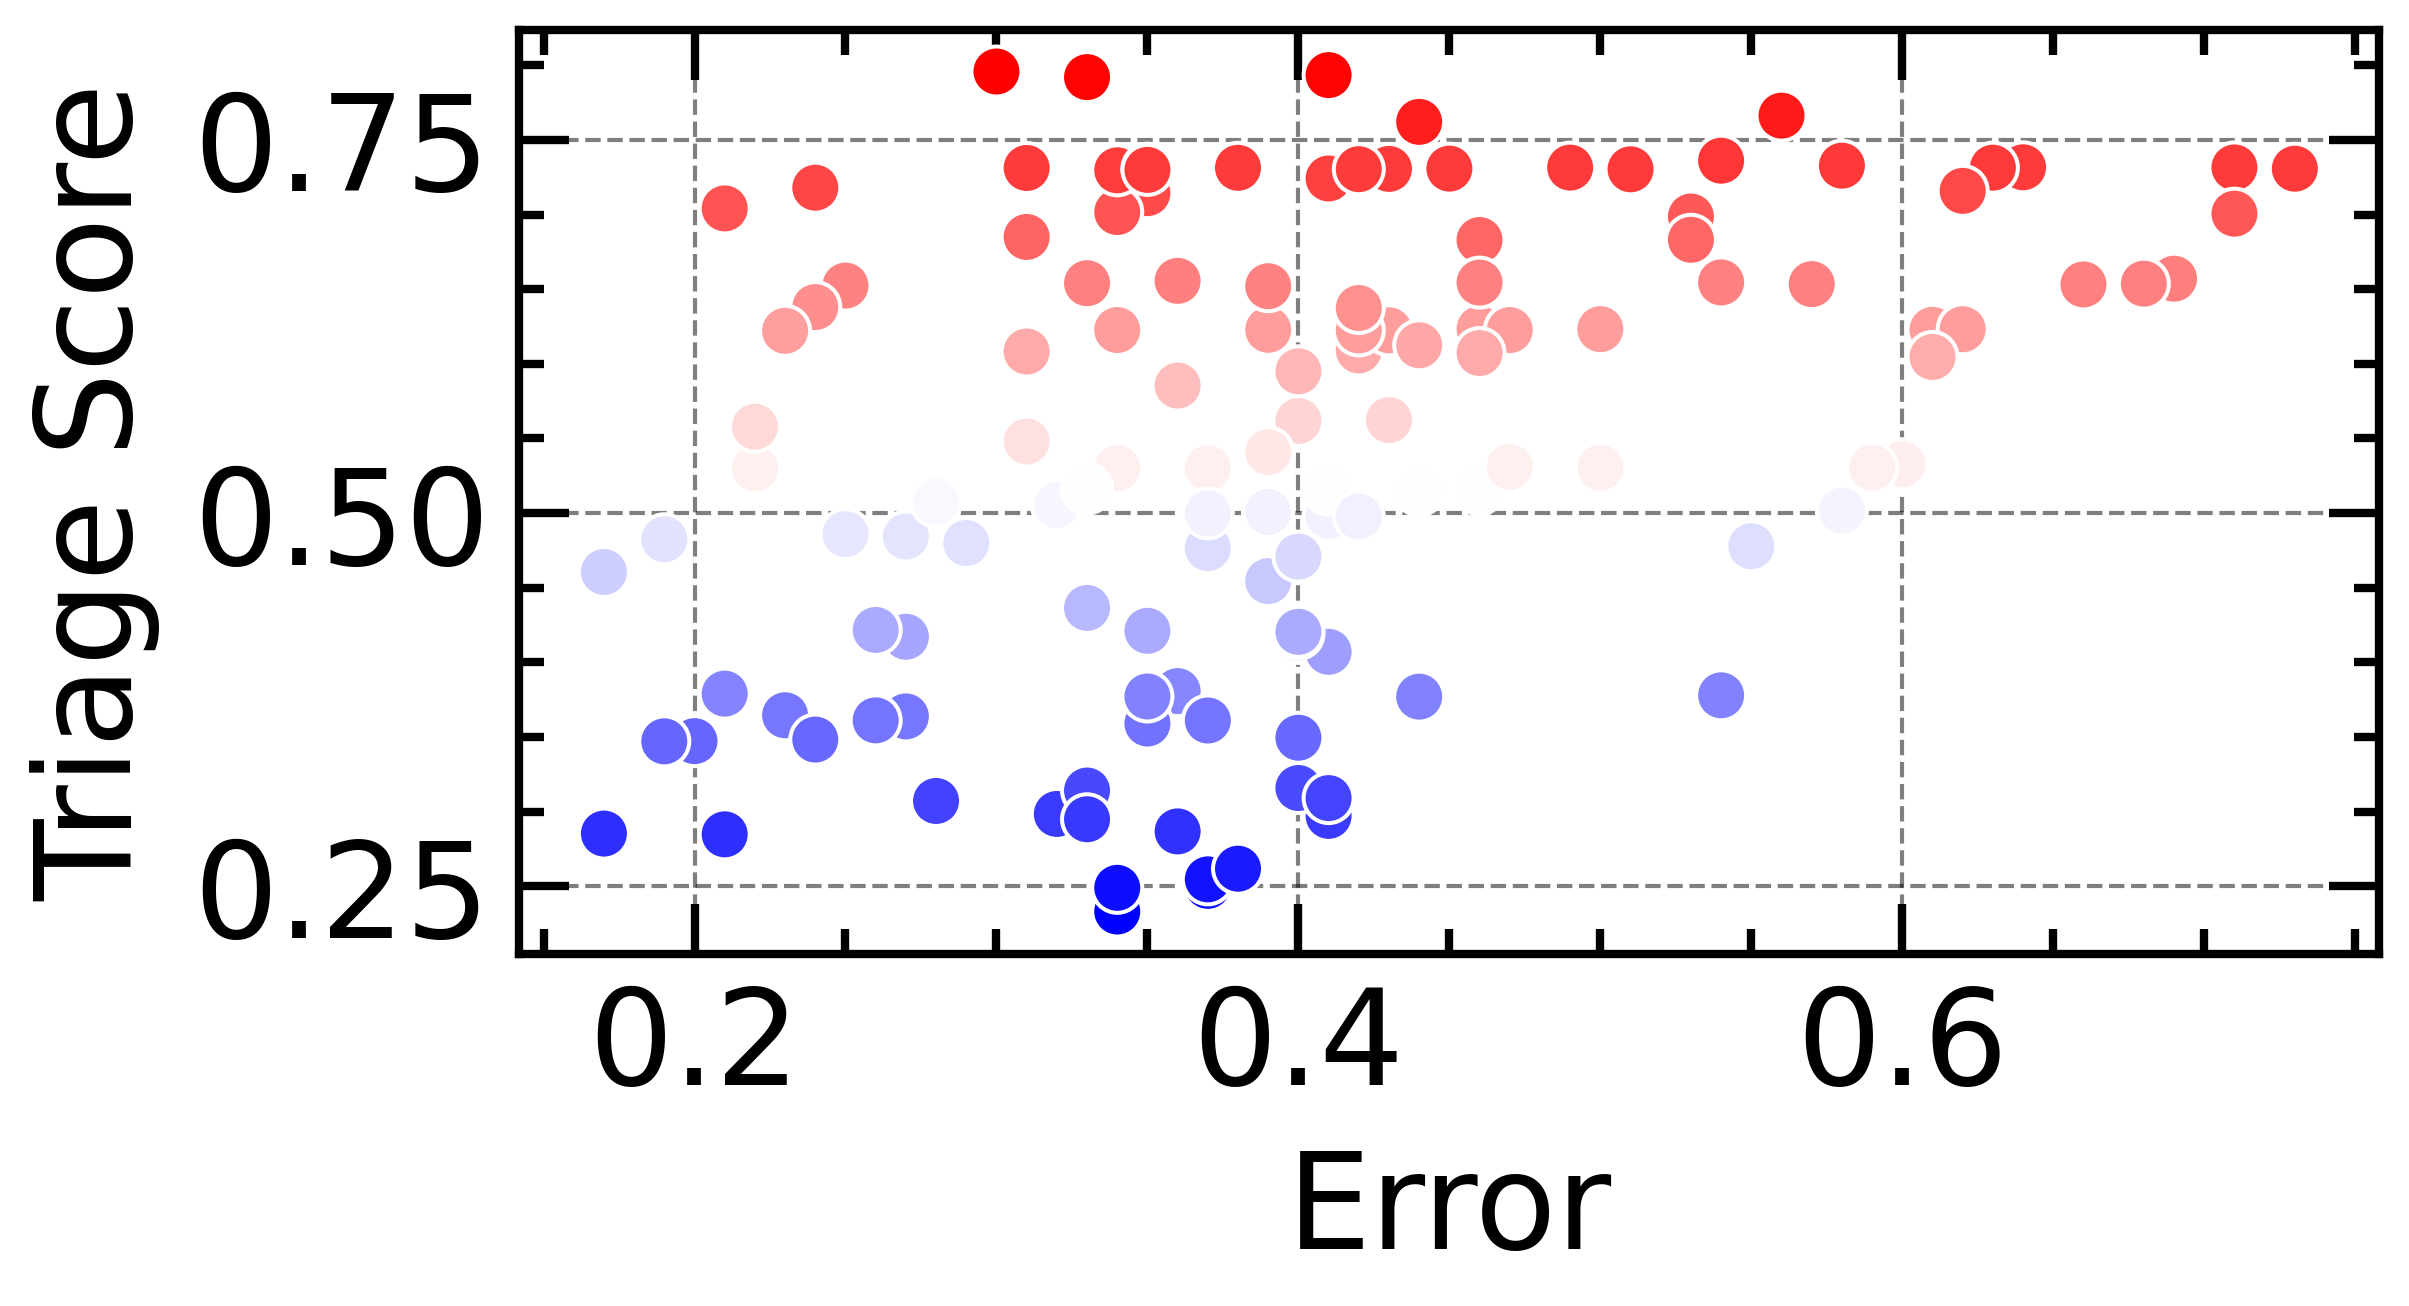

In [10]:
colors = ["bwr"]

for color in colors:

    plt.figure(figsize=(4, 2))

    upper = 0.8
    lower = 0.2

    ids_select = np.where((confidence < upper) & (confidence > lower))[0]

    ax = sns.scatterplot(
        x=np.round(errors_array[ids_select, -1], 2),
        y=np.mean(triage_metric[ids_select, :], axis=1),
        hue=np.mean(triage_metric[ids_select, :], axis=1),
        palette=color,
    )

    norm = plt.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(cmap=color, norm=norm)
    sm.set_array([])

    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    plt.xlabel("Error")
    plt.ylabel("Triage Score")

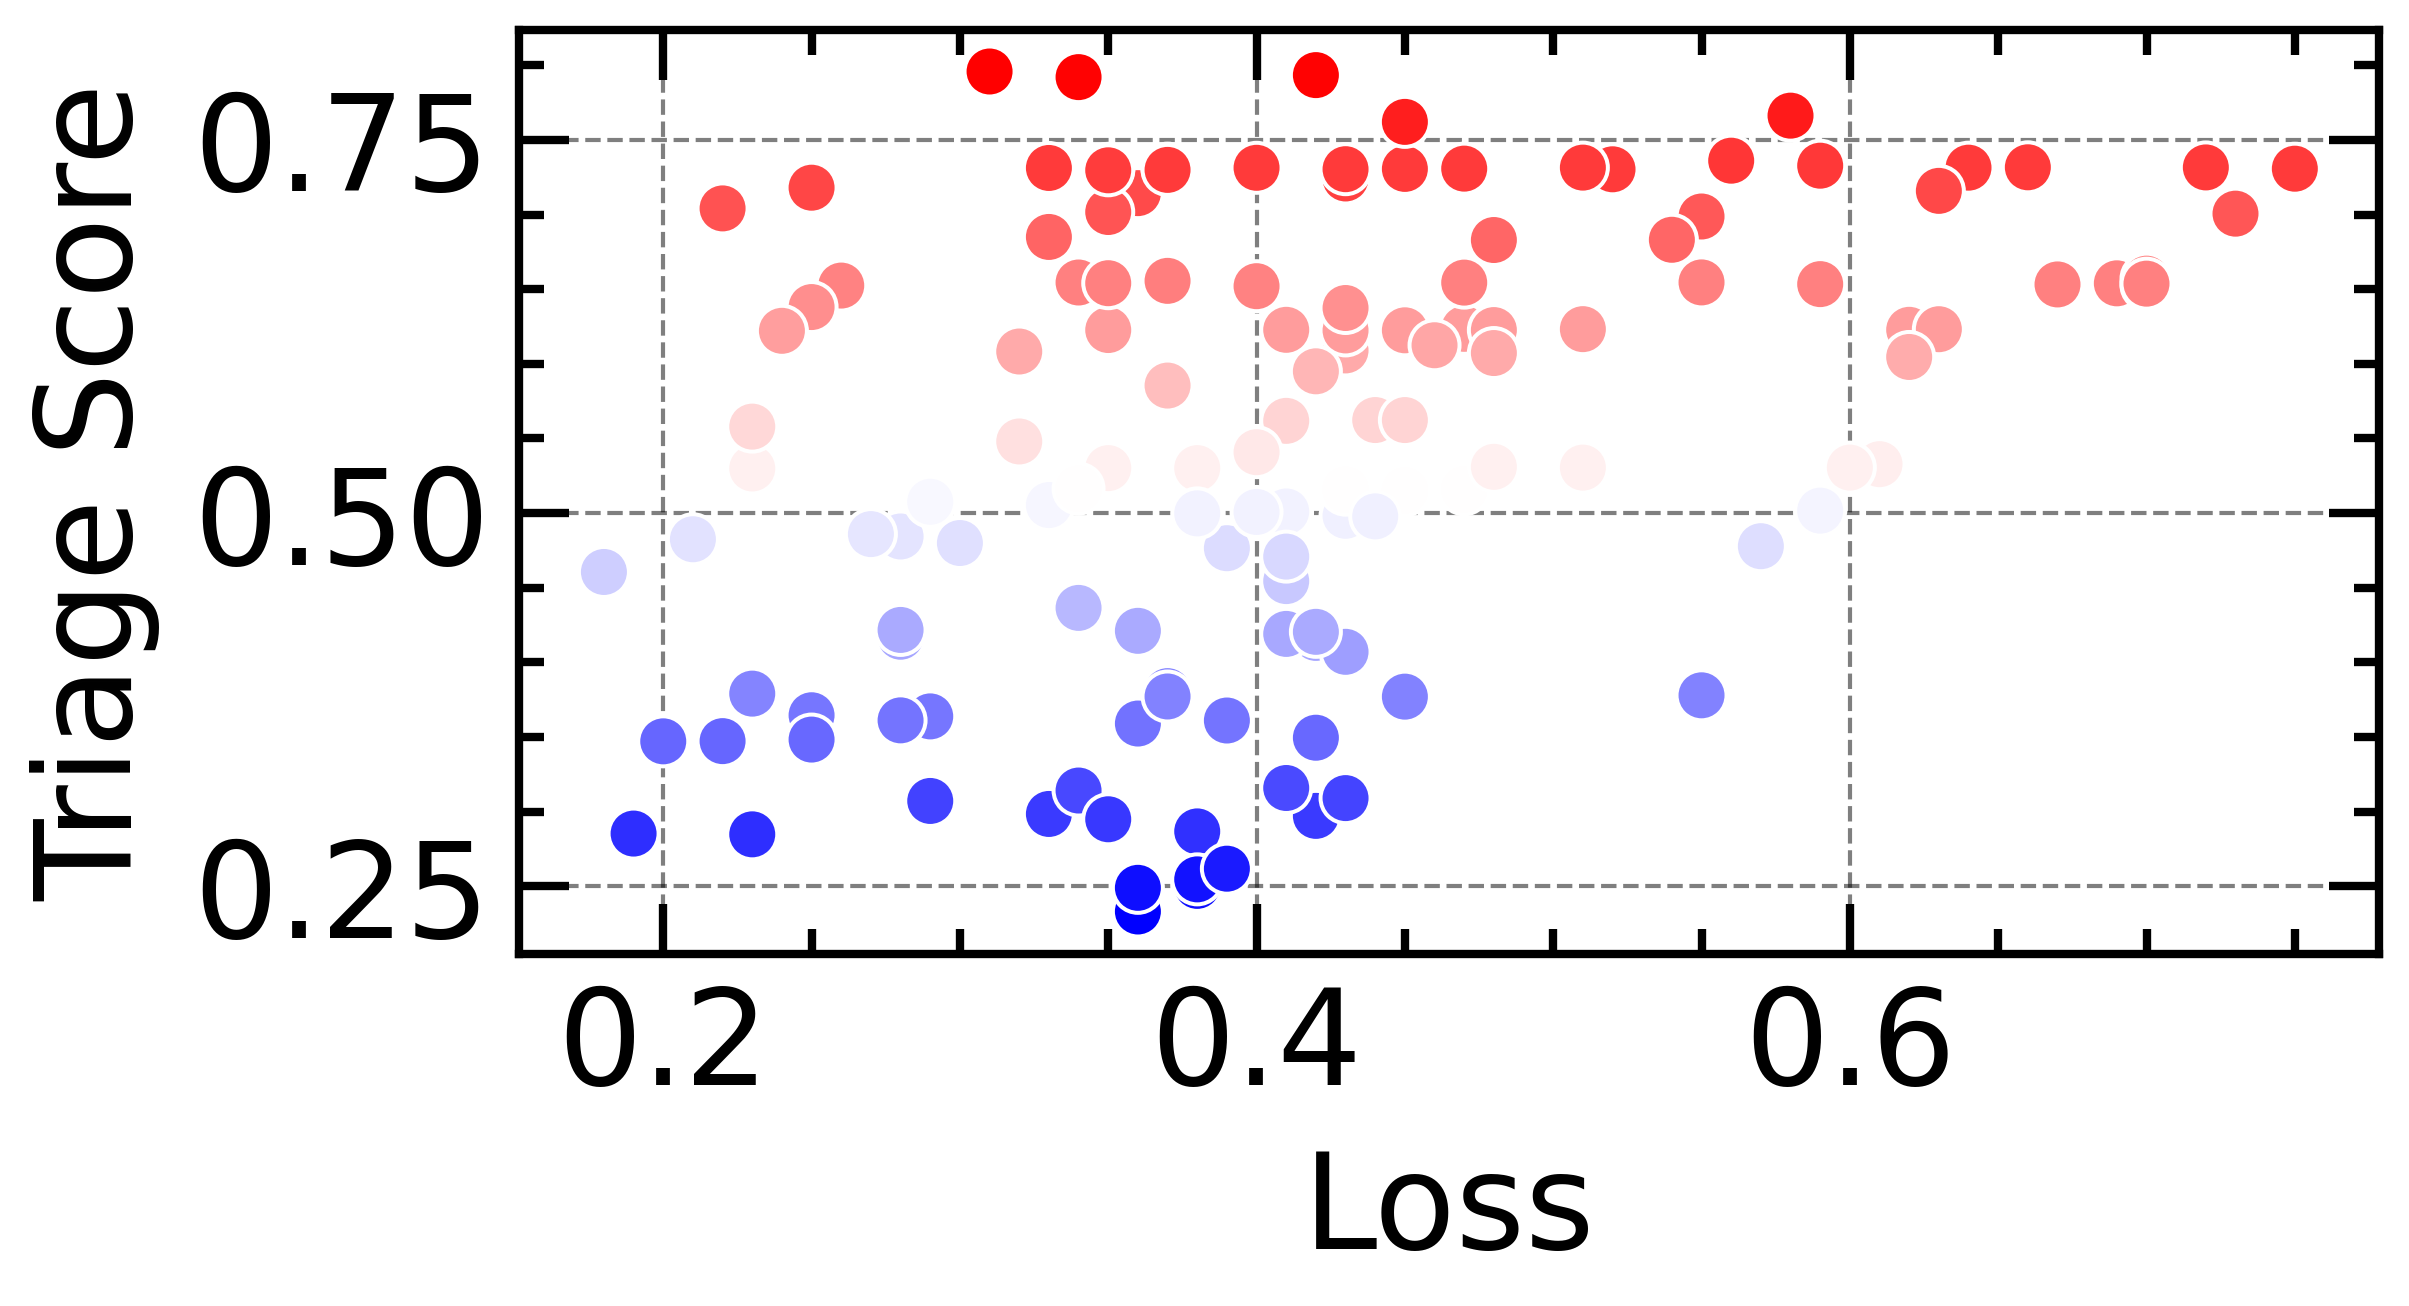

In [11]:
loss_mean = np.mean(loss_values, axis=1)

for color in colors:

    plt.figure(figsize=(4, 2))

    upper = 0.8
    lower = 0.2

    ids_select = np.where((confidence < upper) & (confidence > lower))[0]

    ax = sns.scatterplot(
        x=np.round(loss_mean[ids_select], 2),
        y=np.mean(triage_metric[ids_select, :], axis=1),
        hue=np.mean(triage_metric[ids_select, :], axis=1),
        palette=color,
    )

    norm = plt.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(cmap=color, norm=norm)
    sm.set_array([])

    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    plt.xlabel("Loss")
    plt.ylabel("Triage Score")

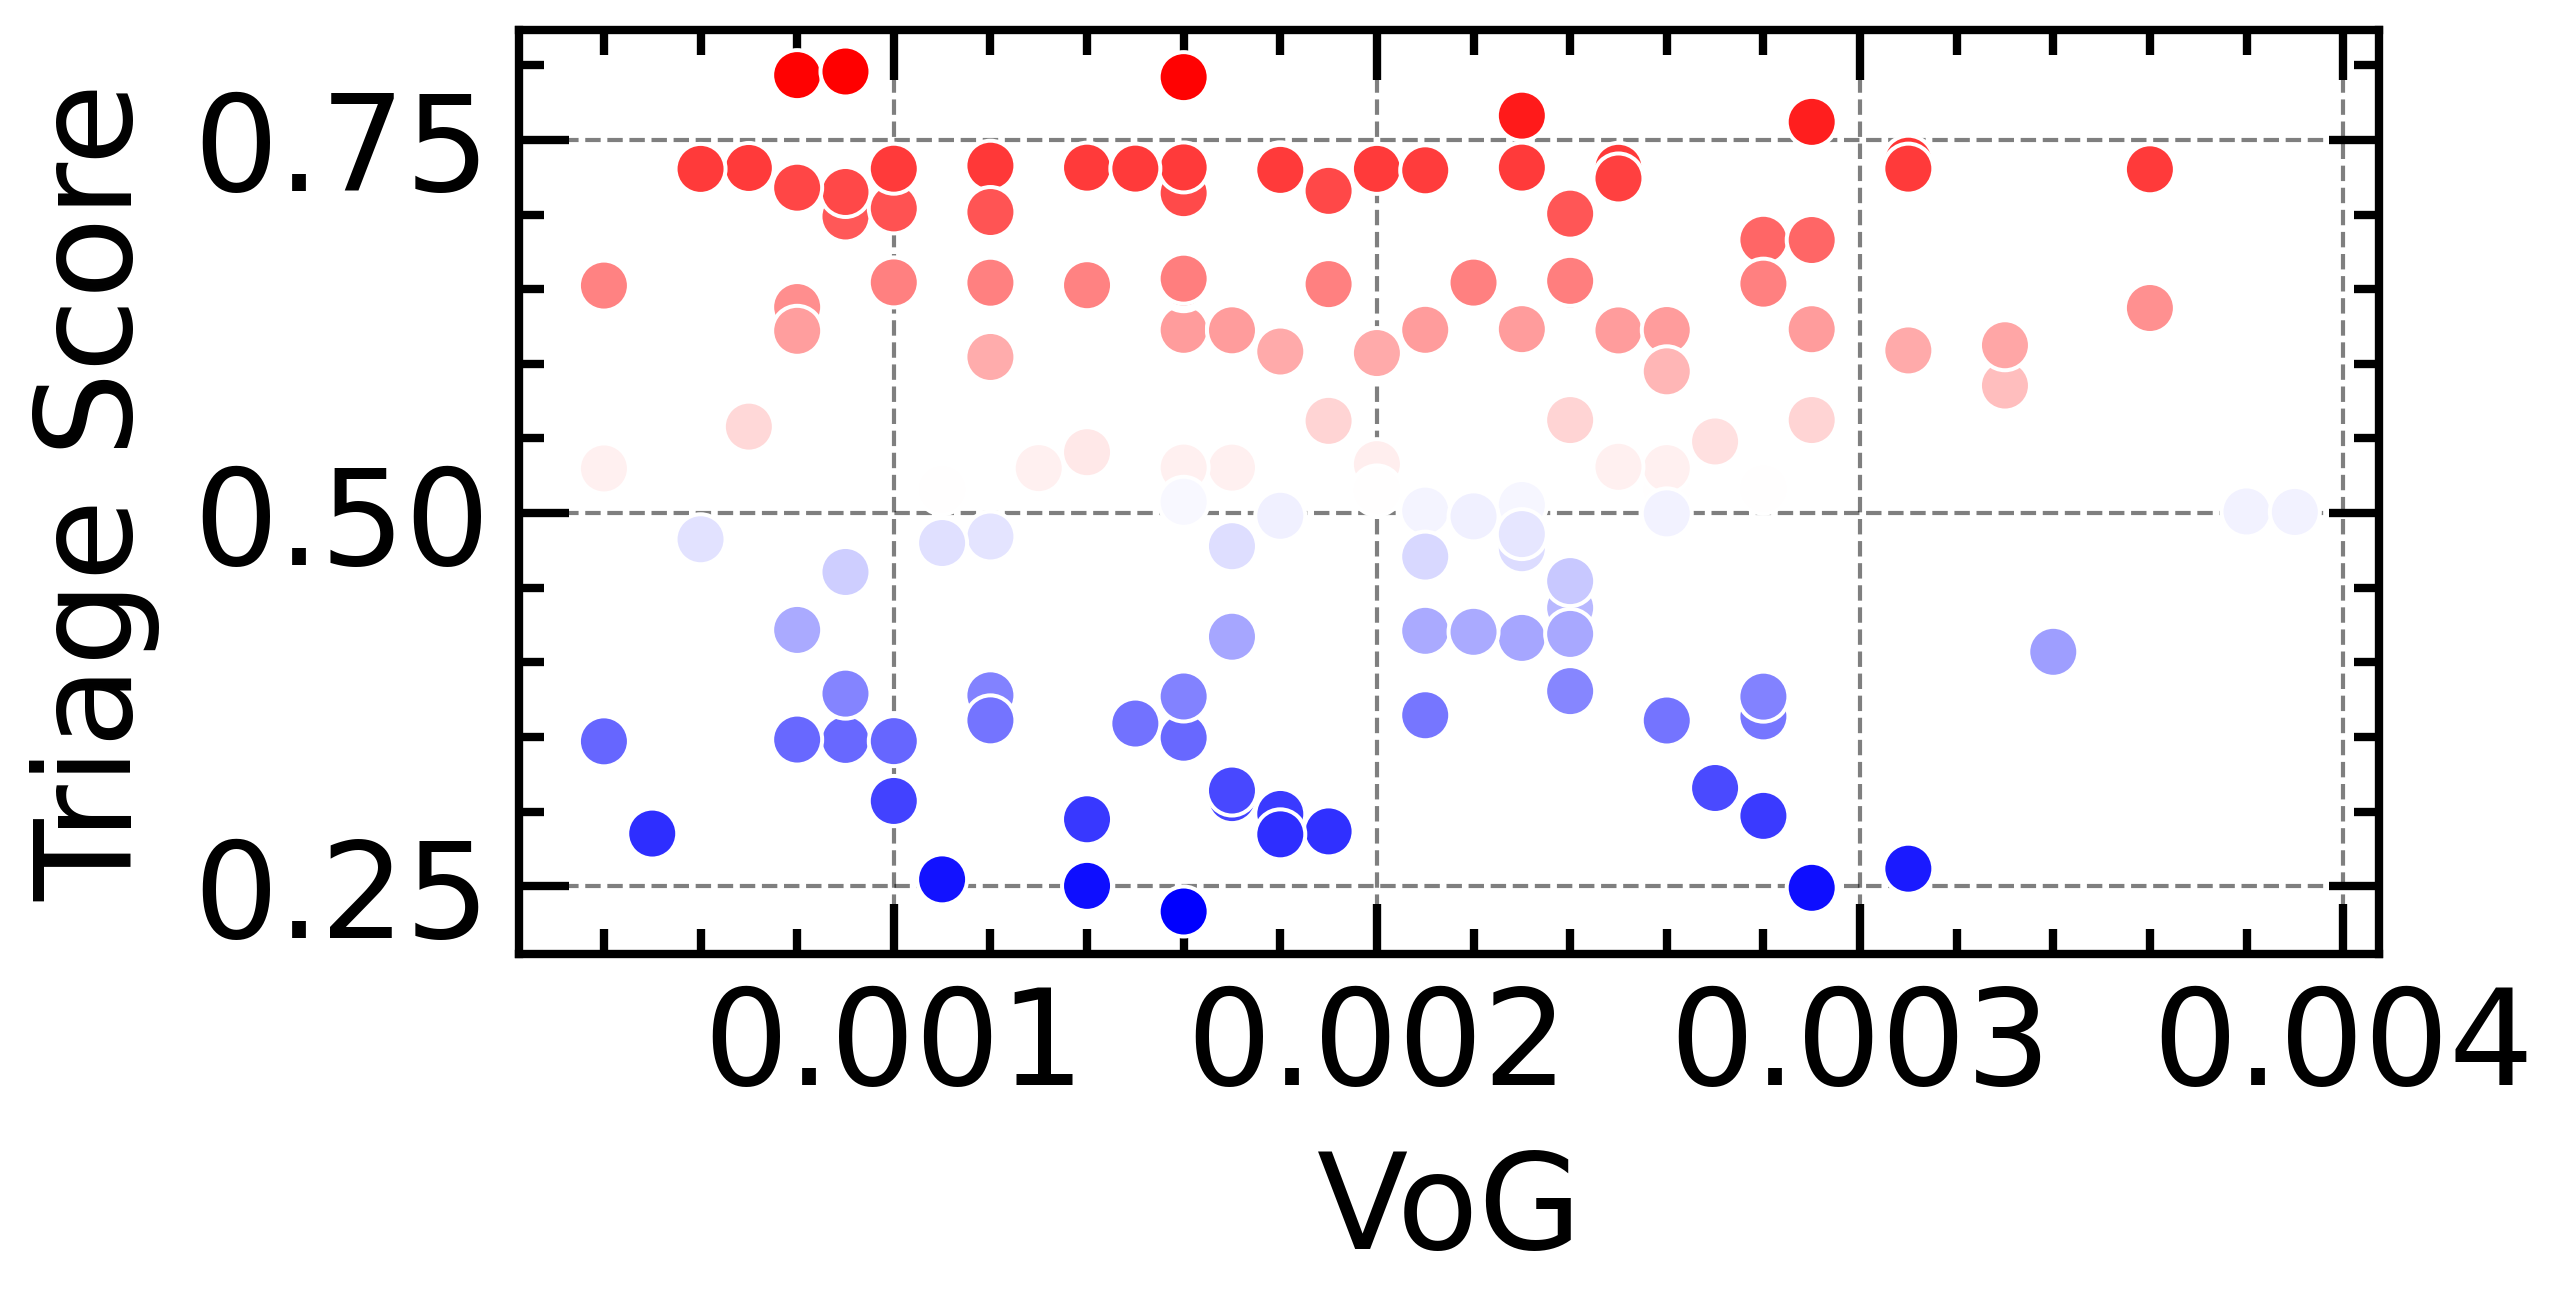

In [12]:
vog = np.array(training_vog_stats)

for color in colors:

    plt.figure(figsize=(4, 2))

    upper = 0.8
    lower = 0.2

    ids_select = np.where((confidence < upper) & (confidence > lower))[0]

    ax = sns.scatterplot(
        x=np.round(vog[ids_select], 4),
        y=np.mean(triage_metric[ids_select, :], axis=1),
        hue=np.mean(triage_metric[ids_select, :], axis=1),
        palette=color,
    )

    norm = plt.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(cmap=color, norm=norm)
    sm.set_array([])

    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    plt.xlabel("VoG")
    plt.ylabel("Triage Score")

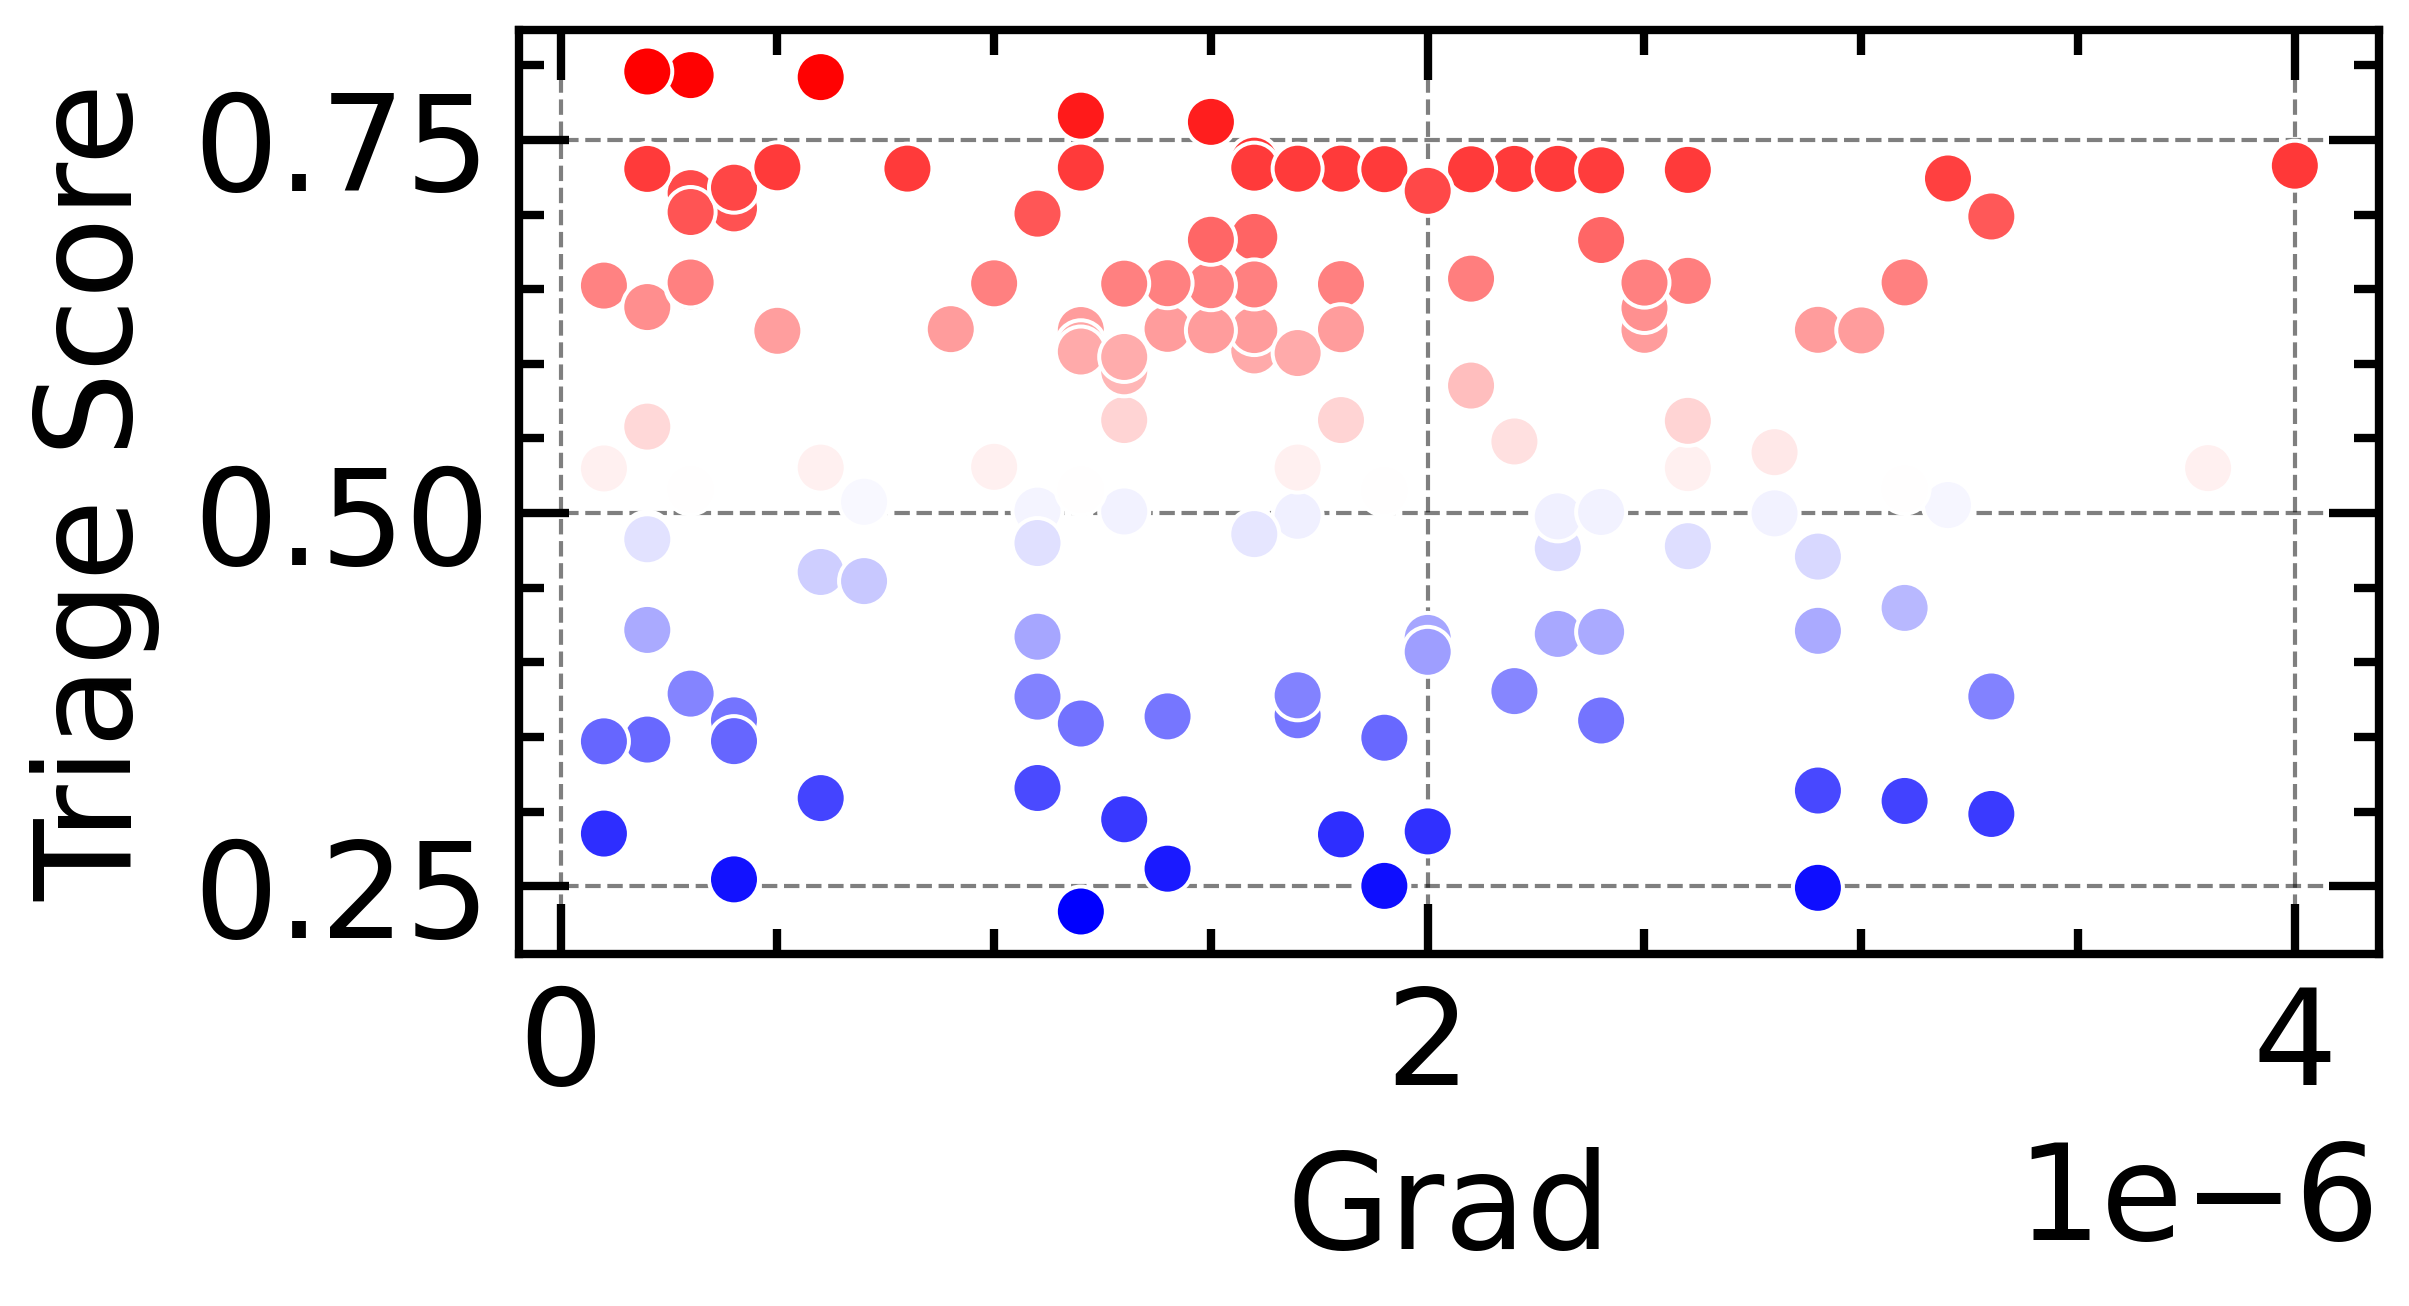

In [13]:
grad_score = np.mean(np.array(gn._grads), axis=-1)

for color in colors:

    plt.figure(figsize=(4, 2))

    upper = 0.8
    lower = 0.2

    ids_select = np.where((confidence < upper) & (confidence > lower))[0]

    ax = sns.scatterplot(
        x=np.round(grad_score[ids_select], 7),
        y=np.mean(triage_metric[ids_select, :], axis=1),
        hue=np.mean(triage_metric[ids_select, :], axis=1),
        palette=color,
    )

    norm = plt.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(cmap=color, norm=norm)
    sm.set_array([])

    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    plt.xlabel("Grad")
    plt.ylabel("Triage Score")